## Vanilla Classification on Full Dataset
This notebook contains first vanilla run of several classification models on the full dataset. 

In [2]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import gzip

from yellowbrick.classifier import ConfusionMatrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

C:\Users\allis\Anaconda3\envs\merging\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Preprocessing

In [36]:
# import data and convert to pandas dataframe
dataset = pd.read_parquet('newdata_v2.parquet', engine = 'pyarrow')

In [37]:
# check if read correctly
dataset.head()

,lat,lon,MaxFRP,EVI,EVI2,NVDI,NIR_reflectance,SWIR1_reflectance,SWIR2_reflectance,SWIR3_reflectance,...,SoilTMP100_200cm_inst,SoilTMP10_40cm_inst,SoilTMP40_100cm_inst,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,Uncertainty,QA,label
0,-46.173406,106.360530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
1,-46.173406,106.405485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
2,-46.173406,106.450441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
3,-46.173406,106.495396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
4,-46.173406,106.540352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water


In [38]:
# check class imbalance
dataset['label'].value_counts()

water           649240
burned          369925
fwi_high         11823
land              2463
fwi_moderate       732
active_fire        193
Name: label, dtype: int64

In [39]:
# Split data into X and y
# Need to save coordinates AFTER train test split in order to merge at end

X = dataset.drop('label', axis = 1)
y = dataset['label']

# Predicting categories: ['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire']

In [40]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

In [41]:
# Save coordinates
train_coords = X_train.loc[:,['lat', 'lon']]
test_coords = X_test.loc[:,['lat', 'lon']]

# Drop coordinates from dataset
X_train.drop(['lat','lon'], axis = 1, inplace = True)
X_test.drop(['lat','lon'], axis = 1, inplace = True)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Scaling Data**

In [42]:
# Scale Data
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

# Binarizing is part of OneVsRestClassifier implementation

**Balancing Classes: Oversampling Methods**

In [43]:
# Random Over Sampler
ros = RandomOverSampler(random_state=1)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

In [ ]:
# Smote
sm = SMOTE(random_state=1)
x_smote, y_smote = sm.fit_resample(x_train, y_train)

### Models
1. <a href=#log>Logistic Regression</a>

<a id=log></a>
### Multiclass Logisitic Regression

In [24]:
lr = LogisticRegression(penalty = 'l1', solver = 'saga',n_jobs = -1)

In [25]:
trained_model = lr.fit(x_resampled, y_resampled)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [26]:
trained_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# Save trained model
dump(trained_model, 'lg_newv2_oversamp.joblib')

['lg_newv2_oversamp.joblib']

In [28]:
y_pred_train = trained_model.predict(x_train)

In [29]:
# Metrics
balanced_accuracy_score(y_train, y_pred_train)

0.8553998919740673

In [30]:
y_pred_test = trained_model.predict(x_test)
balanced_accuracy_score(y_test, y_pred_test)

0.837051527548879

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/jupyter/.local/lib/python3.5/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


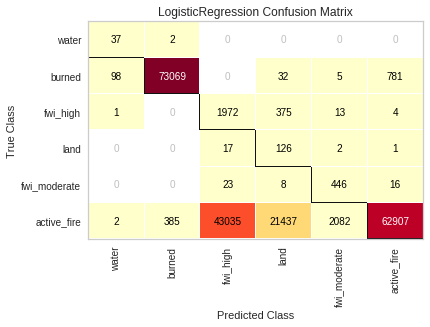

In [31]:
cm_train = ConfusionMatrix(trained_model, classes =['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire'])
cm_train.score(x_test, y_test)
cm_train.show()

## Random Forest

In [34]:
rc = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_split = 1000, n_jobs = -1)

In [44]:
trained_model = rc.fit(x_resampled, y_resampled)

In [45]:
trained_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [46]:
# Save trained model
dump(trained_model, 'rc_newv2_oversamp.joblib')

['rc_newv2_oversamp.joblib']

In [3]:
trained_model = load('../../finalproj_models/rc_newv2_oversamp.joblib')

In [6]:
features = ['MaxFRP', 'EVI', 'EVI2', 'NVDI', 'NIR_reflectance',
       'SWIR1_reflectance', 'SWIR2_reflectance', 'SWIR3_reflectance',
       'VI_Quality', 'blue_reflectance', 'composite_day_of_the_year',
       'green_reflectance', 'pixel_reliability', 'red_reflectance',
       'relative_azimuth_angle', 'sun_zenith_angle', 'view_zenith_angle',
       'gaugeQualityInfo', 'hourlyPrecipRate', 'hourlyPrecipRateGC',
       'observationTimeFlag', 'satelliteInfoFlag', 'Albedo_inst',
       'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg', 'ESoil_tavg',
       'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'PotEvap_tavg',
       'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg',
       'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg', 'RootMoist_inst',
       'SWE_inst', 'SWdown_f_tavg', 'SnowDepth_inst', 'Snowf_tavg',
       'SoilMoi100_200cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst',
       'SoilTMP0_10cm_inst', 'SoilMoi0_10cm_inst', 'SoilTMP100_200cm_inst',
       'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst', 'Swnet_tavg',
       'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst', 'Uncertainty', 'QA']

In [4]:
feat_percent = []
for value in trained_model.feature_importances_:
    feat_percent.append(value*100)

In [7]:
feature_selection = pd.DataFrame(zip(features, feat_percent))

In [8]:
feature_selection.sort_values(by = 1, ascending = False)

,0,1
0,MaxFRP,12.596625
58,QA,11.603749
19,hourlyPrecipRateGC,9.380837
8,VI_Quality,3.820454
53,Swnet_tavg,2.990471
12,pixel_reliability,2.814310
28,LWdown_f_tavg,2.742756
30,PotEvap_tavg,2.739976
56,Wind_f_inst,2.684210
18,hourlyPrecipRate,2.521853


In [11]:
list(feature_selection.loc[feature_selection[1] < 1, 0])

['EVI',
 'EVI2',
 'NVDI',
 'NIR_reflectance',
 'SWIR1_reflectance',
 'SWIR2_reflectance',
 'composite_day_of_the_year',
 'green_reflectance',
 'red_reflectance',
 'relative_azimuth_angle',
 'sun_zenith_angle',
 'view_zenith_angle',
 'gaugeQualityInfo',
 'observationTimeFlag',
 'satelliteInfoFlag',
 'ECanop_tavg',
 'Qg_tavg',
 'Qh_tavg',
 'Qs_acc',
 'Qsm_acc',
 'SWE_inst',
 'SWdown_f_tavg',
 'SnowDepth_inst',
 'Snowf_tavg',
 'SoilMoi40_100cm_inst',
 'SoilTMP10_40cm_inst',
 'Tveg_tavg',
 'Uncertainty']

In [64]:
y_pred_train = trained_model.predict(x_train)

In [65]:
# Metrics
balanced_accuracy_score(y_train, y_pred_train)

0.9073041841005717

In [66]:
y_pred_test = trained_model.predict(x_test)
balanced_accuracy_score(y_test, y_pred_test)

0.8548821576386195

In [ ]:
cm_train = ConfusionMatrix(trained_model, classes =['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire'])
cm_train.score(x_test, y_test)
cm_train.show()

### Create Output of Predictions on All Data for Mapping